In [1]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re, os
from string import printable
from sklearn import model_selection

#import gensim
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json, load_model
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.layers import Input, ELU, LSTM, Embedding, Convolution2D, MaxPooling2D, \
BatchNormalization, Convolution1D, MaxPooling1D, concatenate
from keras.preprocessing import sequence
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K

from pathlib import Path
import json


from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.



## Deep Learning 


Requirements:

- tensorflow 1.4.1
- keras 2.1.2


## Preprocess 

In [2]:
## Load data code_snippet
DATA_HOME = 'DL/'
Final_Labeled_Dataset = pd.read_csv('Dataset of IoT OSs code - training.csv', encoding= 'unicode_escape')
Final_Labeled_Dataset.sample(n=5).head(5) 

,code,isMalicious
2,"sat_send1 ( char *sa , u int 8_t length )",1
2300,staticvoid good1 ( ) { goto sink ; sink:...,0
2269,staticvoid good1 ( ) { if ( 5!= 5 ) ...,0
2341,staticvoid good2 ( ) { if ( staticRetu...,0
2147,staticvoid good2 ( ) { if ( stATIC_CO...,0


In [3]:
Final_Labeled_Dataset.dropna(inplace=True)
Final_Labeled_Dataset.drop_duplicates(inplace=True)
Final_Labeled_Dataset.sample(n=5).head(5) 

,code,isMalicious
2337,staticvoid good2 ( ) { if ( stATIC_CO...,0
2919,staticvoid goodB2G1 ( ) { char * data ; ...,0
223,if ( ( pa_cmd -> addr_len != 0 && pa_cmd ...,5
2847,staticvoid goodB2G2 ( ) { char * data ; ...,0
2894,staticvoid goodG2B1 ( ) { char * data ; ...,0


In [4]:
Final_Labeled_Dataset.shape

(3255, 2)

In [5]:
code_snippet_int_tokens = [[printable.index(x) + 1 for x in code_snippet if x in printable] 
                           for code_snippet in Final_Labeled_Dataset.code]
max_len = 150
X = sequence.pad_sequences(code_snippet_int_tokens, maxlen=max_len)
target = np.array (Final_Labeled_Dataset.isMalicious)
print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (3255, 150) Vector dimension of target:  (3255,)


In [6]:
# Simple Cross-Validation: Split the data set into training and test data
X_train, X_test, target_train, target_test = model_selection.train_test_split(X, target, test_size=0.30, random_state=30)

In [7]:
# GENERAL get layer dimensions for any model!
def print_layers_dims(model):
    l_layers = model.layers
    # Note None is ALWAYS batch_size
    for i in range(len(l_layers)):
        print(l_layers[i])
        print('Input Shape: ', l_layers[i].input_shape, 'Output Shape: ', l_layers[i].output_shape)

# GENERAL save model to disk function!
def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    #have h5py installed
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)
    

# GENERAL load model from disk function!
def load_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    with open(fileModelJSON, 'r') as f:
         model_json = json.load(f)
         model = model_from_json(model_json)
    
    model.load_weights(fileWeights)
    return model

In [8]:
## Deep Learning model Definition --- RNN Training Model 3 --- (Simple LSTM)

def simple_lstm(max_len=150, emb_dim=32, max_vocab_len=150, lstm_output_size=32, W_reg=regularizers.l2(1e-4)):
    # Input
    main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
    # Embedding layer
    emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
                dropout=0.2, W_regularizer=W_reg)(main_input) 

    # LSTM layer
    lstm = LSTM(lstm_output_size)(emb)
    lstm = Dropout(0.5)(lstm)
    
    # Output layer (last fully connected layer)
    output = Dense(55, activation='sigmoid', name='output')(lstm)

    # Compile model and define optimizer
    model = Model(input=[main_input], output=[output])
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

Epoch 1/5
2278/2278 [==============================] - 8s 3ms/step - loss: 4.0033 - acc: 0.0759
Epoch 2/5
2278/2278 [==============================] - 6s 3ms/step - loss: 3.9914 - acc: 0.3674
Epoch 3/5
2278/2278 [==============================] - 6s 3ms/step - loss: 3.9737 - acc: 0.4552
Epoch 4/5
2278/2278 [==============================] - 6s 3ms/step - loss: 3.9381 - acc: 0.4653
Epoch 5/5
977/977 [==============================] - 1s 1ms/step
dict_keys(['acc', 'loss'])


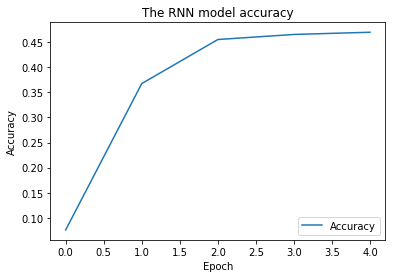


Final Cross-Validation Accuracy of RNN training model 0.49232343958734615 



In [9]:
# Fit model and Cross-Validation, ARCHITECTURE 1 SIMPLE LSTM
epochs = 5
batch_size = 64

RNN_model = simple_lstm()
history = RNN_model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size)
loss, accuracy = RNN_model.evaluate(X_test, target_test, verbose=1)

print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['loss'])
plt.title('The RNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='lower right')
plt.show()


print('\nFinal Cross-Validation Accuracy of RNN training model', accuracy, '\n')

In [10]:
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 32)           4800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 55)                1815      
Total params: 14,935
Trainable params: 14,935
Non-trainable params: 0
_________________________________________________________________
